In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import joblib
from imblearn.over_sampling import SMOTE

# Function to capture column names based on dtype

In [2]:
# the function to find out the column names based on the dtype
def column_types(loan_df):
    
    # separating numeric columns and object columns and float columns into three variables for label encoding and for limiting decimal points
    numerical_cols = loan_df.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
    non_numerical_cols = loan_df.select_dtypes(include=['object', 'category']).columns.tolist()
    float_columns = loan_df.select_dtypes(include='float64').columns.tolist()

    # print(f"numerical_cols : {numerical_cols} \n\n non_numerical_cols : {non_numerical_cols} \n\n float_columns : {float_columns} \n\n")

    return numerical_cols, non_numerical_cols, float_columns

# All numerical columns are continuous columns and all non-numerical columns are categorical columns in the given dataset

# Function to limit the decimal points to 4 for float columns

In [3]:
# Function to limit the decmail points to 4 for the float columns
def decimal_four(loan_df):
    # limiting the decimal points to 4 for each float columns
    num, non_num, float_col = column_types(loan_df)
    loan_df[float_col] = loan_df[float_col].round(4)

    return loan_df

# Function to add extra columns

In [4]:
# Function to add extra feature columns for better prediction
def add_feature(loan_df):
    # Creating AGE_GROUP column to the dataset based on the age
    loan_df['Age_Group'] = pd.cut(loan_df['Age'], 
                                  bins=[17, 30, 50, 65, 100], 
                                  labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])

    # Creating Credit_Score_Group column from Credit_Score column
    loan_df['Credit_Score_Group'] = pd.cut(loan_df['Credit_Score'], 
                                           bins=[125, 580, 670, 740, 850], 
                                           labels=['Poor', 'Fair', 'Good', 'Excellent'])

    # Creating DTI_Bins column into the dataset
    loan_df['DTI_Group'] = pd.cut(loan_df['Debt_to_Income_Ratio'], 
                                  bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                                  labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

    # Finding out EMI from Loan amount, Interest rate and Loan Duration in months column
    loan_df['Monthly_Loan_Payment'] = (loan_df['Loan_Amount'] * 
                                       (loan_df['Interest_Rate'] / 100)) / loan_df['Loan_Duration_Months']

    # Calculate Interest to Income Ratio from Interset rate, loan amount and income
    # how much of the applicant’s income is spent on paying interest alone for their loan. 
    # It helps in assessing whether the interest payments will be manageable based on the person's earnings.
    loan_df['Interest_to_Income_Ratio'] = ((loan_df['Interest_Rate'] * 
                                            loan_df['Loan_Amount']) / loan_df['Income']).round(4)

    # Calculate Loan to Income Ratio using the loan amount and income column
    # the proportion of the borrower’s income that the loan amount represents. 
    # tell us the applicant's borrowing capacity and whether the loan is reasonable compared to their earnings.
    loan_df['Loan_to_Income_Ratio'] = (loan_df['Loan_Amount'] / loan_df['Income']).round(4)

    # calling the decimal_four() function
    loan_df = decimal_four(loan_df)

    loan_df.to_csv("Added_Extra_columns.csv",index=False)
    
    return loan_df

# Function for plotting categorical columns

In [5]:
# Functions to plot categorical columns
def cat_plot(col_name,loan_df):
    
    loan_df_copy = loan_df.copy()
    # Bar plot for a categorical column (e.g., 'Gender') vs target column 'Loan_Status'
    ax = sns.countplot(x=col_name, hue='Loan_Status', data=loan_df_copy)
    for p in ax.patches:
        height = p.get_height()
        if height == 0:
            continue
        ax.annotate(f"{int(height)}",
                   (p.get_x() + p.get_width() / 2.,height),
                   ha = 'center', va = 'bottom',
                    fontsize = 10, color = 'black')
    
    plt.title(f'{col_name} Distribution by Loan Status')
    plt.show()

# Function for plotting continuous columnns

In [6]:
# Function to plot continuous columns
def con_plot(col_name,loan_df):

    loan_df_copy = loan_df.copy()
    # FacetGrid for a continuous column with respect to 'Loan_Status'
    g = sns.FacetGrid(loan_df, col='Loan_Status')
    
    # Plotting histograms
    g.map(sns.histplot, col_name, kde=True, bins=30)
    
    # Rename the facet column titles
    g.set_titles(col_template="{col_name}")  # Replace the default titles with the actual status labels
    g.axes[0, 0].set_title('Default')       # Set title for Loan_Status = 0 (Default)
    g.axes[0, 1].set_title('Non_Default')    # Set title for Loan_Status = 1 (Non_Default)
    
    g.add_legend()
    plt.show()

# Function to plot all columns against target column "Loan_Status"

In [7]:
# Function to call both continuous plot and categorical plot together
def plotting(categorical_cols,continuous_cols,loan_df):
    for col in categorical_cols:
        cat_plot(col,loan_df)
    # Plotting for continuous value columns
    for con_cols in continuous_cols:
        con_plot(con_cols,loan_df)

# Function for LabelEncoding

In [8]:
# Function for label encoding
def label_encoding(loan_df):
    numerical_cols, non_numerical_cols, float_columns = column_types(loan_df)

    categorical_cols = non_numerical_cols.copy()

    continuous_cols = numerical_cols.copy()

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Dictionary to store the mappings for each column
    label_mappings = {}
    
    # Apply Label Encoding to each Non-Numerical Column and store mappings in the variable
    for col in non_numerical_cols:
        # Fit and transform the column
        loan_df[col] = label_encoder.fit_transform(loan_df[col].astype(str))
        
        # Capture the mapping of strings to numbers into lable_mappings variable
        mapping = {label: idx for idx, label in enumerate(label_encoder.classes_)}
        label_mappings[col] = mapping

    # Display the mappings
    print("The following are the label encoded values")
    for col, mapping in label_mappings.items():
        print(f"Label Encoding for {col}: {mapping}")

    loan_df.to_csv("Label_encoded1.csv")

    return label_mappings, loan_df, continuous_cols, categorical_cols

In [9]:
# Function to print the label mappings
def encoded_labels(labels):
    # Display the mappings
    print("The following are the label encoded values")
    for col, mapping in labels.items():
        print(f"Label Encoding for {col}: {mapping}")

# Now the label encoding is done now we need to standardise or normalize categorical columns and continuous coulmns separately

In [10]:
def preprocessing_df(loan_df,categorical_cols,continuous_cols):
    numerical_cols, non_numerical_cols, float_columns = column_types(loan_df)

    print(f"categorical_cols : {categorical_cols}")
    print()
    print(f"continuous_cols : {continuous_cols}")
    # OneHotEncoder for categorical values
    # Create the OneHotEncoder instance
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    # Fit and transform the categorical columns
    encoded_cols = encoder.fit_transform(loan_df[categorical_cols])
    # Creating a DataFrame with the encoded columns and get the feature names
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))
    # Drop the original categorical columns from loan_df
    loan_df = loan_df.drop(columns=categorical_cols)
    # Concatenate the original DataFrame with the new encoded DataFrame
    loan_df = pd.concat([loan_df, encoded_df], axis=1)

    # MinMaxScaler for continuous columns
    scaler = MinMaxScaler()
    loan_df[continuous_cols] = scaler.fit_transform(loan_df[continuous_cols])

    # Calling decimal four function
    loan_df = decimal_four(loan_df)

    # Save the normalized dataset into a new file
    loan_df.to_csv('Normalized.csv')

    return loan_df

# Function to split data

In [11]:
def xy_split(loan_df):

    # Define features and target variable
    X = loan_df.drop('Loan_Status', axis=1)
    y = loan_df['Loan_Status']
    
    # Normalize feature
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return loan_df, X_train, X_test, y_train, y_test

# Function to handle class imbalance using SMOTE

In [12]:
def classimbalance_smote(loan_df,X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Print the class distribution after over-sampling
    print("Class distribution after SMOTE Oversampling:", y_train.value_counts())

    return loan_df,X_train, y_train

# Funtion to show Feature Importance

In [13]:
def feat_imp(loan_df,X_train, y_train):
    # Train Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for feature importances
    features = loan_df.drop('Loan_Status', axis=1).columns
    feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
    
    # Sort by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    # Print feature importances
    print(feature_importances)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

    return loan_df, importances, features

# From the above feature importance select the least deature imporatance you need and paste the value below

In [14]:
# # Access column names where importance is below 0.076945
# low_importance_features = feature_importances[feature_importances['Importance'] < 0.058212]
# # Get the feature names
# low_importance_column_names = low_importance_features['Feature'].tolist()
# loan_df.drop(columns=low_importance_column_names, inplace=True)

# Model Training

# Function for Displaying matrix values

In [15]:
# Print model metrics
def print_model_metrics(model_name, model, y_true, y_pred, X_test):

    print(f"{model_name} Metrics:")
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, model.predict_proba(X_test)[:, 1]))
    print("\n")

# Function for ROC Curve 

In [16]:
# Function to plot the ROC Curve
def plot_roc_curve(model_name, model, X_test, y_test):
    # Get the predicted probabilities (for the positive class)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Dashed diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Function for training the model with default values

In [17]:
# Updated model training function with ROC curve plotting
def model_training(X_train, y_train, X_test, y_test):

    # Dictionary to store model name and model object
    models = {}
    
    # LOGISTIC REGRESSION
    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train, y_train)
    # Make predictions
    y_pred_log_reg = log_reg.predict(X_test)
    # Store the model
    models["Logistic Regression"] = [log_reg,'log_reg']
    # Evaluate the model
    print_model_metrics("Logistic Regression", log_reg, y_test, y_pred_log_reg, X_test)
    plot_roc_curve("Logistic Regression", log_reg, X_test, y_test)

    # DECISION TREE
    decision_tree = DecisionTreeClassifier(random_state=42)
    decision_tree.fit(X_train, y_train)
    # Make predictions
    y_pred_tree = decision_tree.predict(X_test)
    # Store the model
    models["Decision Tree"] = [decision_tree,'decision_tree']
    # Evaluate the model
    print_model_metrics("Decision Tree", decision_tree, y_test, y_pred_tree, X_test)
    plot_roc_curve("Decision Tree", decision_tree, X_test, y_test)

    # RANDOM FOREST
    random_forest = RandomForestClassifier(random_state=42)
    random_forest.fit(X_train, y_train)
    # Make predictions
    y_pred_rf = random_forest.predict(X_test)
    # Store the model
    models["Random Forest"] = [random_forest,'random_forest']
    # Evaluate the model
    print_model_metrics("Random Forest", random_forest, y_test, y_pred_rf, X_test)
    plot_roc_curve("Random Forest", random_forest, X_test, y_test)

    # SVM (Support Vector Machines)
    svm = SVC(random_state=42, probability=True)  # Set probability=True for ROC curve
    svm.fit(X_train, y_train)
    # Make predictions
    y_pred_svm = svm.predict(X_test)
    # Store the model
    models["SVM"] = [svm,'svm']
    # Evaluate the model
    print_model_metrics("SVM", svm, y_test, y_pred_svm, X_test)
    plot_roc_curve("SVM", svm, X_test, y_test)

    return models

# Function to get hyperparameter values

In [18]:
def hyp_tun(X_train, y_train, X_test, y_test):

    # Logistic regression model 
    def hyp_logre(X_train, y_train):
        
        # Define the parameter grid for Logistic Regression
        param_grid_log_reg = {
            'C': [0.001, 0.01, 0.1, 2, 10, 100],  # Regularization strength
            'solver': ['liblinear', 'saga', 'newton-cg', 'sag'],      # Solvers suitable for small datasets
            'max_iter': [90, 110, 200, 300]           # Number of iterations
        }
        
        # Initialize the model
        log_reg = LogisticRegression(random_state=42)
        
        # Initialize GridSearchCV
        grid_search_log_reg = GridSearchCV(estimator=log_reg, param_grid=param_grid_log_reg,
                                            scoring='accuracy', cv=5, n_jobs=-1)
        
        # Fit GridSearchCV
        grid_search_log_reg.fit(X_train, y_train)
        
        # Best parameters and score
        best_params_l = grid_search_log_reg.best_params_
        best_score_l = grid_search_log_reg.best_score_
        
        # Best parameters and best score
        print("Logistic Regresion")
        print("Best Parameters for Logistic Regression:", grid_search_log_reg.best_params_)
        print("Best Score for Logistic Regression:", grid_search_log_reg.best_score_)
        print()
        
        C_l = best_params_l['C']
        solver = best_params_l['solver']
        max_iter = best_params_l['max_iter']

        return C_l, solver, max_iter
    
    # Decision tree and random forest model
    def hyp_dtrf(X_train, y_train):
    
        # Define the parameter grid
        param_grid_rf = {
            'n_estimators': [90, 100, 150, 200, 300],
            'max_depth': [10, 20, 30],
            'min_samples_split': [4, 5, 7, 10],
            'min_samples_leaf': [2, 3, 4]
        }
        
        # Initialize RandomizedSearchCV
        rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, n_iter=10, cv=5, random_state=42, n_jobs=-1)
        
        # Fit the model
        rf_search.fit(X_train, y_train)
        
        # Best parameters and score
        best_params_r = rf_search.best_params_
        best_score_r = rf_search.best_score_
        
        # Best parameters and score
        print("Decision Tree and Random Forest")
        print("Best Parameters:", rf_search.best_params_)
        print("Best Score:", rf_search.best_score_)
        print()
        
        # Assign best parameters to individual variables
        n_estimators = best_params_r['n_estimators']
        max_depth = best_params_r['max_depth']
        min_samples_split = best_params_r['min_samples_split']
        min_samples_leaf = best_params_r['min_samples_leaf']
    
        return n_estimators, max_depth, min_samples_leaf, min_samples_split

    # SVM model
    def hyp_svm(X_train, y_train):
        
        # Define the parameter grid for SVM
        param_grid_svm = {
            'C': [0.001, 0.01, 0.1, 1, 2, 10, 100],  # Regularization parameter
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types
            'gamma': ['scale', 'auto', 0.1, 1, 5, 10]  # Kernel coefficient
        }
        
        # Initialize the model
        svm = SVC(random_state=42)
        
        # Initialize GridSearchCV
        grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm,
                                        scoring='accuracy', cv=5, n_jobs=-1)
        
        # Fit GridSearchCV
        grid_search_svm.fit(X_train, y_train)
        
        # Best parameters and score
        best_params_s = grid_search_svm.best_params_
        best_score_s = grid_search_svm.best_score_
        
        # Best parameters and best score
        print("Support Vector Machine")
        print("Best Parameters for SVM:", grid_search_svm.best_params_)
        print("Best Score for SVM:", grid_search_svm.best_score_)
        print()
        
        C_s = best_params_s['C']
        kernel = best_params_s['kernel']
        gamma = best_params_s['gamma']

        return C_s, kernel, gamma


    # Call both hyperparameter tuning functions
    rf_results = hyp_dtrf(X_train, y_train)
    log_reg_results = hyp_logre(X_train, y_train)
    svm_results = hyp_svm(X_train, y_train)

    # Combine results from both models
    return (*rf_results, *log_reg_results, *svm_results)

# Funtion to apply Hyper Parameter Values into models

In [19]:
# Function to train models and plot ROC curves
def hy_model_training(X_train, y_train, X_test, y_test, C_l, max_iter, solver, 
                      min_samples_split, min_samples_leaf, max_depth, 
                      n_estimators, C_s, gamma, kernel):

    # Dictionary to store model name and model object
    hyp_models = {}

    # LOGISTIC REGRESSION
    hyp_log_reg = LogisticRegression(C=C_l, max_iter=max_iter, solver=solver, random_state=42)
    hyp_log_reg.fit(X_train, y_train)
    y_pred_log_reg = hyp_log_reg.predict(X_test)
    # Store the model
    hyp_models["Logistic Regression"] = [hyp_log_reg,'hyp_log_reg']
    # Calling print_model_metrics function
    # hy_log_reg = print_model_metrics("Logistic Regression", hyp_log_reg, y_test, y_pred_log_reg, X_test)
    print_model_metrics("Logistic Regression", hyp_log_reg, y_test, y_pred_log_reg, X_test)
    # Call plot_roc_curve function
    plot_roc_curve("Logistic Regression", hyp_log_reg, X_test, y_test)

    # DECISION TREE
    hyp_decision_tree = DecisionTreeClassifier(
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        random_state=42
    )
    hyp_decision_tree.fit(X_train, y_train)
    y_pred_tree = hyp_decision_tree.predict(X_test)
    # Store the model
    hyp_models["Decision Tree"] = [hyp_decision_tree,'hyp_decision_tree']
    # hyp_decision_tr = print_model_metrics("Decision Tree", hyp_decision_tree, y_test, y_pred_tree, X_test)
    print_model_metrics("Decision Tree", hyp_decision_tree, y_test, y_pred_tree, X_test)
    plot_roc_curve("Decision Tree", hyp_decision_tree, X_test, y_test)

    # RANDOM FOREST
    hyp_random_forest = RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        random_state=42
    )
    hyp_random_forest.fit(X_train, y_train)
    y_pred_rf = hyp_random_forest.predict(X_test)
    # Store the model
    hyp_models["Random Forest"] = [hyp_random_forest,'hyp_random_forest']
    # hyp_random_fr = print_model_metrics("Random Forest", hyp_random_forest, y_test, y_pred_rf, X_test)
    print_model_metrics("Random Forest", hyp_random_forest, y_test, y_pred_rf, X_test)
    plot_roc_curve("Random Forest", hyp_random_forest, X_test, y_test)
 
    # SVM (with probability=True)
    hyp_svm = SVC(C=C_s, gamma=gamma, kernel=kernel, probability=True, random_state=42)
    hyp_svm.fit(X_train, y_train)
    y_pred_svm = hyp_svm.predict(X_test)
    # Store the model
    hyp_models["SVM"] = [hyp_svm,'hyp_svm']
    # hyp_svm_mdl = print_model_metrics("SVM", hyp_svm, y_test, y_pred_svm, X_test)
    print_model_metrics("SVM", hyp_svm, y_test, y_pred_svm, X_test)
    plot_roc_curve("SVM", hyp_svm, X_test, y_test)
    
    # return hy_log_reg, hyp_decision_tr, hyp_random_fr, hyp_svm_mdl
    return hyp_models


# Function to save the specific model

In [20]:
def save_model(model):
    # Save the SVM model
    print(model)
    joblib.dump(model, 'loan_df_model.pkl')

# Main Function - To load data and to call all other functions

In [21]:
# this is the main function which loads the dataseta and calls all other functions
def main():

    # Load data into python
    loan_df = pd.read_csv('loan_default_prediction_project.csv')
    
    # Fill the NaN columns in the Employment_Status column with the mean of the median value of Employed and Unemployed income
    emp_med = loan_df[loan_df['Employment_Status'] == 'Employed']['Income'].median()
    unemp_med = loan_df[loan_df['Employment_Status'] == 'Unemployed']['Income'].median()
    val = (emp_med + unemp_med) / 2

    # Update null Employment_Status column
    loan_df.loc[(loan_df['Employment_Status'].isnull()) & (loan_df['Income'] >= val), 'Employment_Status'] = 'Employed'
    loan_df.loc[(loan_df['Employment_Status'].isnull()) & (loan_df['Income'] < val), 'Employment_Status'] = 'Unemployed'

    # Fill NaN Gender column cells with Female and Male values alternately
    gen_vals = ['Female', 'Male']
    num_nulls = loan_df['Gender'].isnull().sum()
    gen_vals_l = []

    # Creating a list with Female and Male values with items equal to the number of null cells
    for i in range(num_nulls):
        gen_vals_l.append(gen_vals[i % 2])

    # Fill the null entries with the selected alternating values
    loan_df.loc[loan_df['Gender'].isnull(), 'Gender'] = gen_vals_l

    # calling the decimal_four() function
    loan_df = decimal_four(loan_df)

    # Saving the cleaned dataset into a new file for easy access
    loan_df.to_csv('Null_Values_Handled.csv',index=False)

    # callig the add_feature function to add extra features into the dataframe
    loan_df = add_feature(loan_df)

    # Capturing Categorical, continuous column names
    numerical_cols, non_numerical_cols, float_columns = column_types(loan_df)
    # creating categorical and continuous value columns for plotting
    categorical_cols = non_numerical_cols.copy()
    continuous_cols = numerical_cols.copy()
    # removing target column from categorical columns
    categorical_cols.remove('Loan_Status')
    
    plotting(categorical_cols,continuous_cols,loan_df)

    # calling function for label encoding
    label_mappings, loan_df, continuous_cols, categorical_cols = label_encoding(loan_df)


    categorical_cols.remove("Loan_Status")
    # print(f"categorical_cols : {categorical_cols} \n\n continuous_cols : {continuous_cols} \n\n")
    
    loan_df = preprocessing_df(loan_df,categorical_cols,continuous_cols)

    loan_df, X_train, X_test, y_train, y_test = xy_split(loan_df)

    loan_df,X_train, y_train = classimbalance_smote(loan_df,X_train, y_train)

    loan_df, importances, features = feat_imp(loan_df,X_train, y_train)

    def_models = model_training(X_train, y_train, X_test, y_test)

    n_estimators, max_depth, min_samples_leaf, min_samples_split, C_l, solver, max_iter, C_s, kernel, gamma = hyp_tun(X_train, y_train, X_test, y_test)

    hyp_models = hy_model_training(X_train, y_train, X_test, y_test, C_l, max_iter, solver, 
                      min_samples_split, min_samples_leaf, max_depth, 
                      n_estimators, C_s, gamma, kernel)

    
    # Combine def_models and hyp_models into one dictionary called "models"
    models = {**def_models, **hyp_models}

    # print("Default Models")
    # # Iterate over the dictionary to unpack model name and model
    # for model_name, model in models.items():
    #     print(f"Model_name : {model_name} - Model is : {model}")

    # # Iterate over the dictionary to unpack model name and model
    # for model_name, model in hyp_models.items():
    #     print(f"Model_name : {model_name} - Model is : {model}")
    #     print()
        
    model_l = ['log_reg','decision_tree','random_forest','svm','hyp_log_reg','hyp_decision_tree','hyp_random_forest','hyp_svm']

    print("Select any of the model which you need to save from the list")
    for i in range(len(model_l)):
        print()
        print(f"{i} - {model_l[i]}")

    sel_model = int(input("Enter the model number to save the model (0 to 7) press any other key to exit without saving"))

    if sel_model in range(0,8):
        model_name = model_l[sel_model]
        save_model(model_name)
        print(f"Model : {model_name} saved")
    else:
        pass

    # Return the updated loan_df
    return loan_df

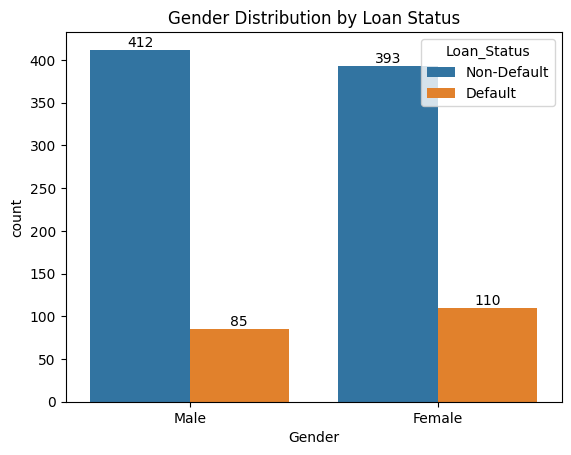

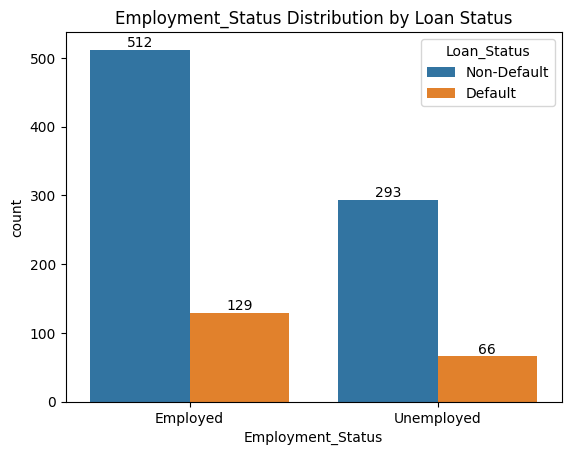

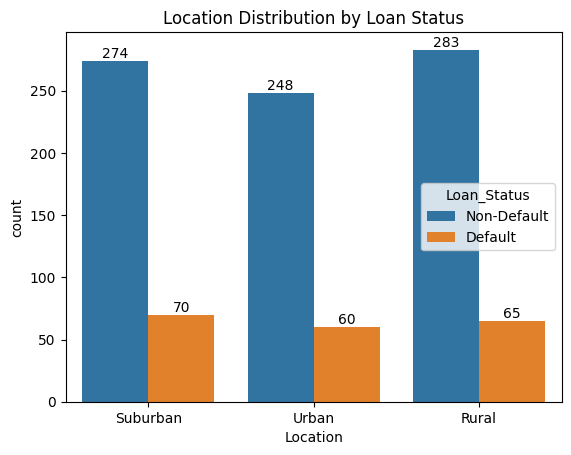

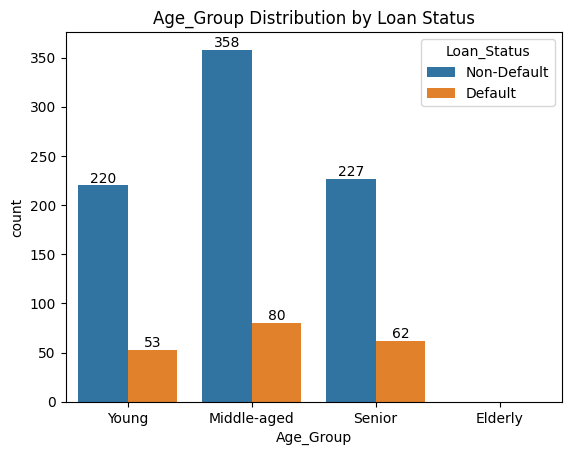

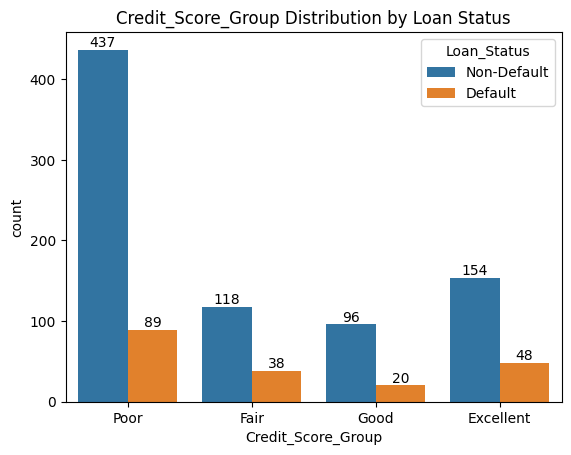

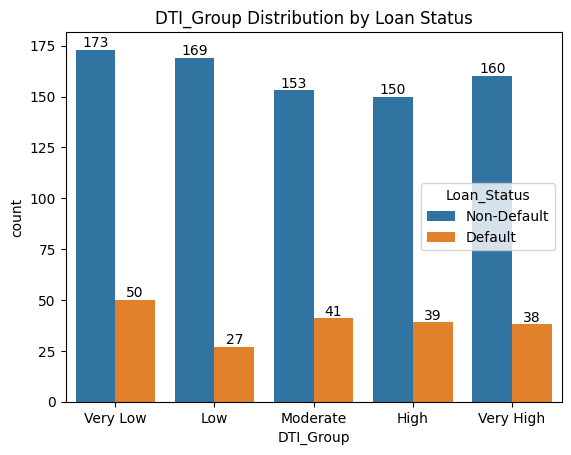

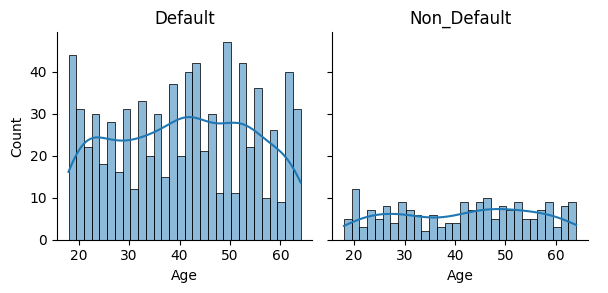

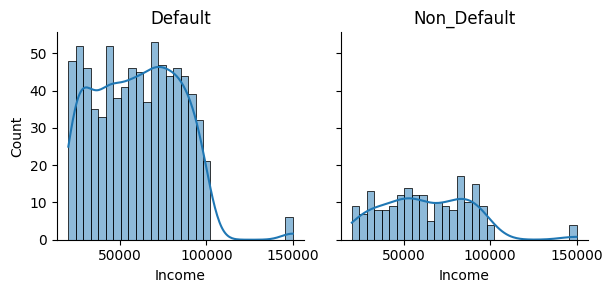

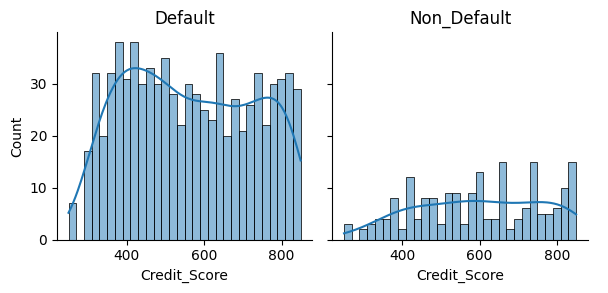

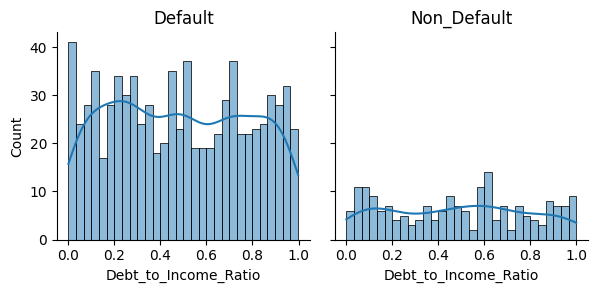

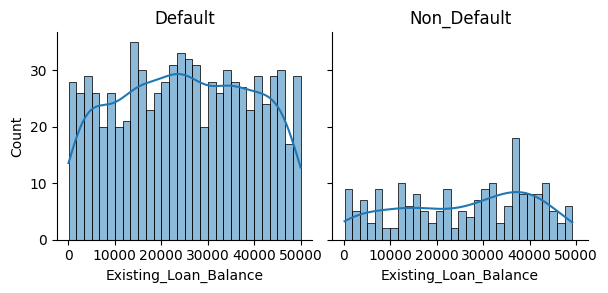

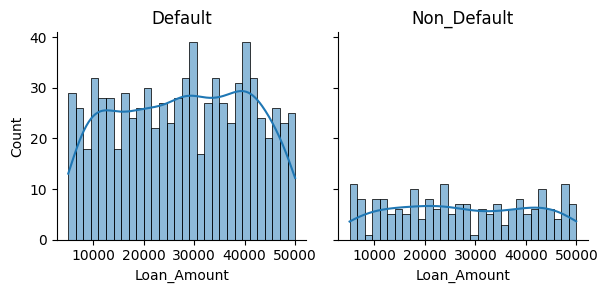

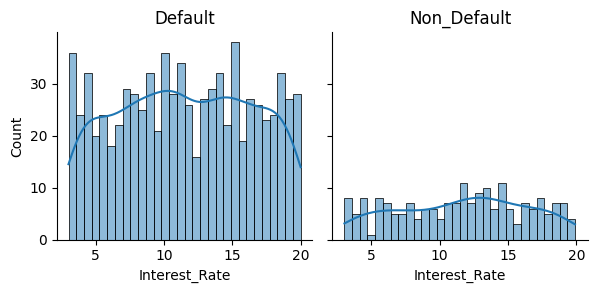

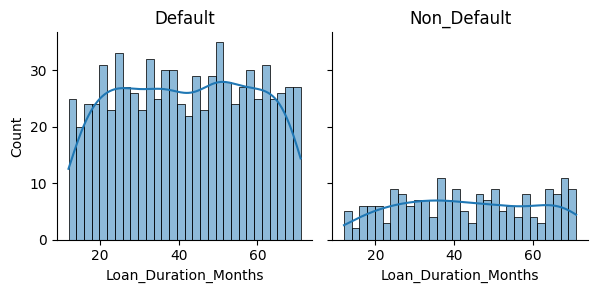

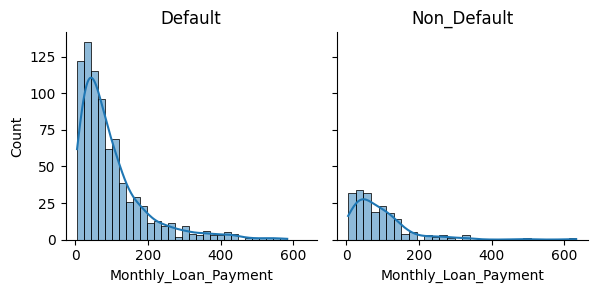

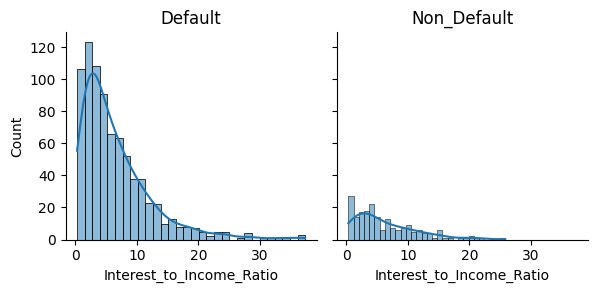

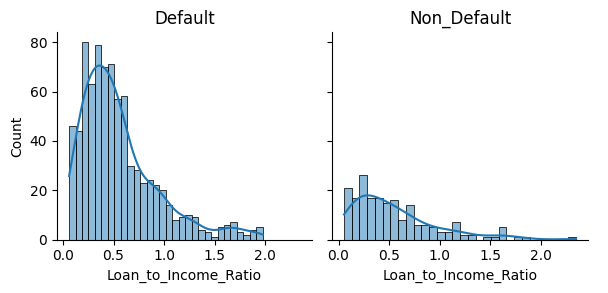

The following are the label encoded values
Label Encoding for Gender: {'Female': 0, 'Male': 1}
Label Encoding for Employment_Status: {'Employed': 0, 'Unemployed': 1}
Label Encoding for Location: {'Rural': 0, 'Suburban': 1, 'Urban': 2}
Label Encoding for Loan_Status: {'Default': 0, 'Non-Default': 1}
Label Encoding for Age_Group: {'Middle-aged': 0, 'Senior': 1, 'Young': 2}
Label Encoding for Credit_Score_Group: {'Excellent': 0, 'Fair': 1, 'Good': 2, 'Poor': 3}
Label Encoding for DTI_Group: {'High': 0, 'Low': 1, 'Moderate': 2, 'Very High': 3, 'Very Low': 4}
categorical_cols : ['Gender', 'Employment_Status', 'Location', 'Age_Group', 'Credit_Score_Group', 'DTI_Group']

continuous_cols : ['Age', 'Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Existing_Loan_Balance', 'Loan_Amount', 'Interest_Rate', 'Loan_Duration_Months', 'Monthly_Loan_Payment', 'Interest_to_Income_Ratio', 'Loan_to_Income_Ratio']
Class distribution after SMOTE Oversampling: Loan_Status
1    565
0    565
Name: count, dtype:

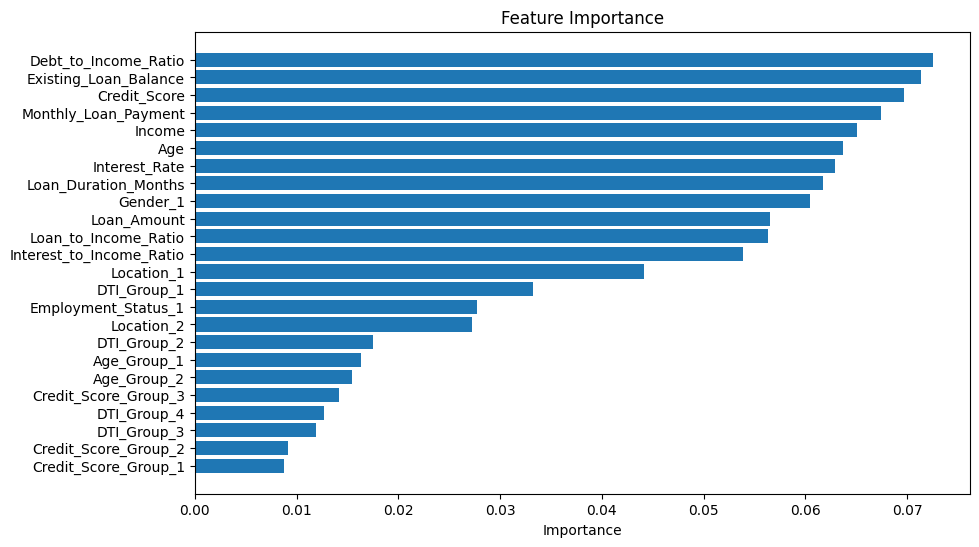

Logistic Regression Metrics:
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.60      0.37        60
           1       0.86      0.59      0.70       240

    accuracy                           0.59       300
   macro avg       0.56      0.60      0.54       300
weighted avg       0.74      0.59      0.63       300

Accuracy: 0.5933333333333334
Precision: 0.8554216867469879
Recall: 0.5916666666666667
F1 Score: 0.6995073891625616
ROC AUC: 0.5667361111111111




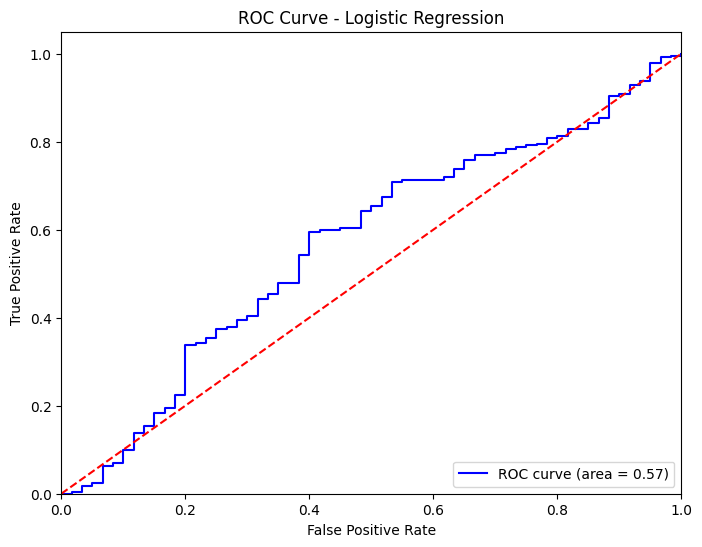

Decision Tree Metrics:
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.25      0.24        60
           1       0.81      0.79      0.80       240

    accuracy                           0.68       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.69      0.68      0.69       300

Accuracy: 0.68
Precision: 0.8076923076923077
Recall: 0.7875
F1 Score: 0.7974683544303798
ROC AUC: 0.51875




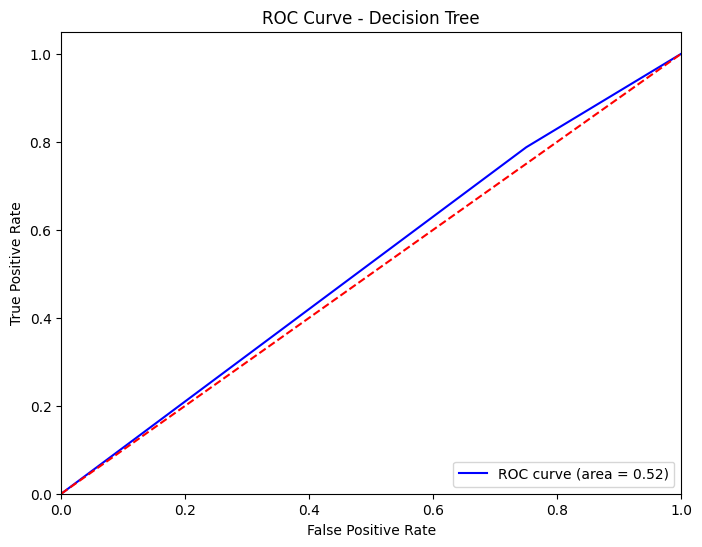

Random Forest Metrics:
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.08      0.12        60
           1       0.80      0.93      0.86       240

    accuracy                           0.76       300
   macro avg       0.51      0.51      0.49       300
weighted avg       0.69      0.76      0.71       300

Accuracy: 0.76
Precision: 0.802158273381295
Recall: 0.9291666666666667
F1 Score: 0.861003861003861
ROC AUC: 0.6048958333333333




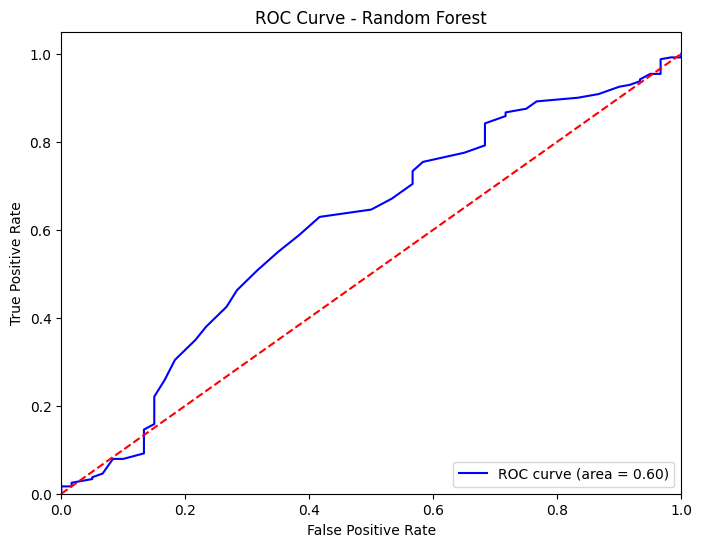

SVM Metrics:
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.25      0.24        60
           1       0.81      0.79      0.80       240

    accuracy                           0.68       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.69      0.68      0.69       300

Accuracy: 0.6833333333333333
Precision: 0.8085106382978723
Recall: 0.7916666666666666
F1 Score: 0.8
ROC AUC: 0.5538194444444445




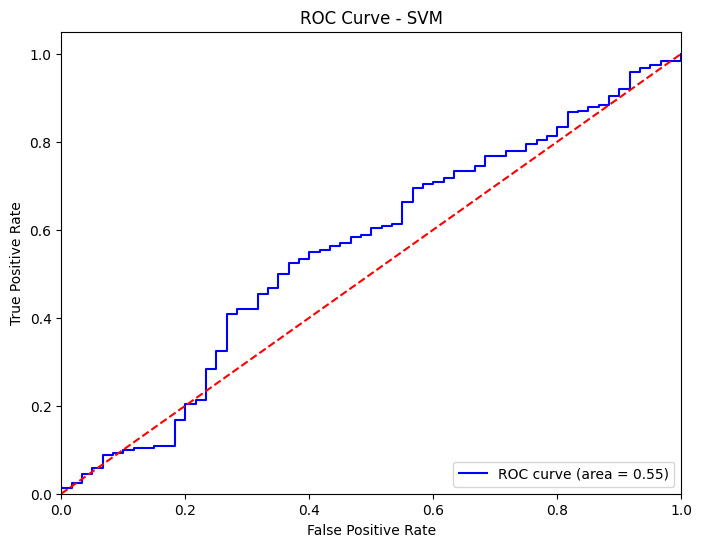

Decision Tree and Random Forest
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
Best Score: 0.8946902654867257

Logistic Regresion
Best Parameters for Logistic Regression: {'C': 2, 'max_iter': 90, 'solver': 'liblinear'}
Best Score for Logistic Regression: 0.611504424778761

Support Vector Machine
Best Parameters for SVM: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score for SVM: 0.9345132743362832

Logistic Regression Metrics:
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.58      0.36        60
           1       0.85      0.60      0.70       240

    accuracy                           0.59       300
   macro avg       0.56      0.59      0.53       300
weighted avg       0.73      0.59      0.63       300

Accuracy: 0.5933333333333334
Precision: 0.8511904761904762
Recall: 0.5958333333333333
F1 Score: 0.7009803921568627
ROC AUC: 0.5664583333333333




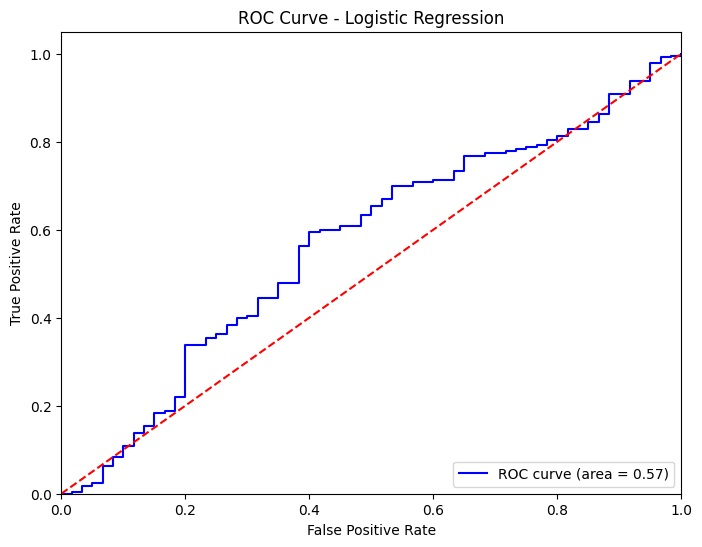

Decision Tree Metrics:
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.33      0.29        60
           1       0.82      0.75      0.78       240

    accuracy                           0.67       300
   macro avg       0.53      0.54      0.53       300
weighted avg       0.70      0.67      0.68       300

Accuracy: 0.6666666666666666
Precision: 0.8181818181818182
Recall: 0.75
F1 Score: 0.782608695652174
ROC AUC: 0.5614930555555555




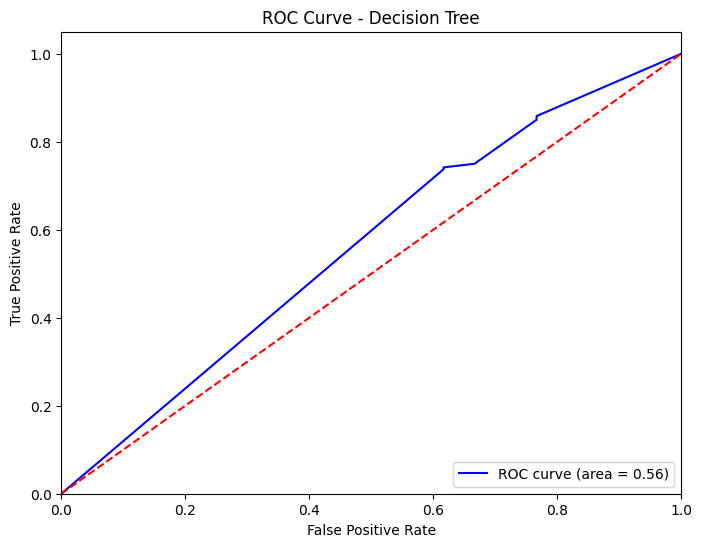

Random Forest Metrics:
Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.07      0.10        60
           1       0.80      0.93      0.86       240

    accuracy                           0.76       300
   macro avg       0.49      0.50      0.48       300
weighted avg       0.68      0.76      0.71       300

Accuracy: 0.7566666666666667
Precision: 0.7992831541218638
Recall: 0.9291666666666667
F1 Score: 0.859344894026975
ROC AUC: 0.6159722222222223




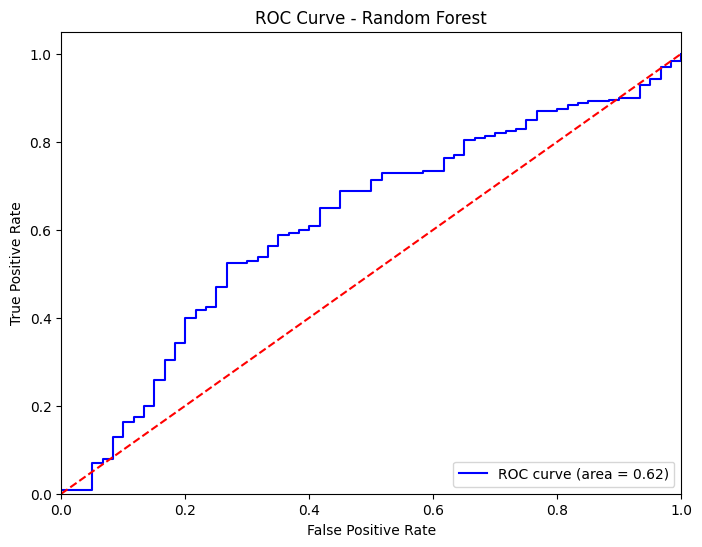

SVM Metrics:
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.07      0.09        60
           1       0.79      0.90      0.84       240

    accuracy                           0.73       300
   macro avg       0.47      0.48      0.47       300
weighted avg       0.66      0.73      0.69       300

Accuracy: 0.7333333333333333
Precision: 0.7941176470588235
Recall: 0.9
F1 Score: 0.84375
ROC AUC: 0.5338888888888889




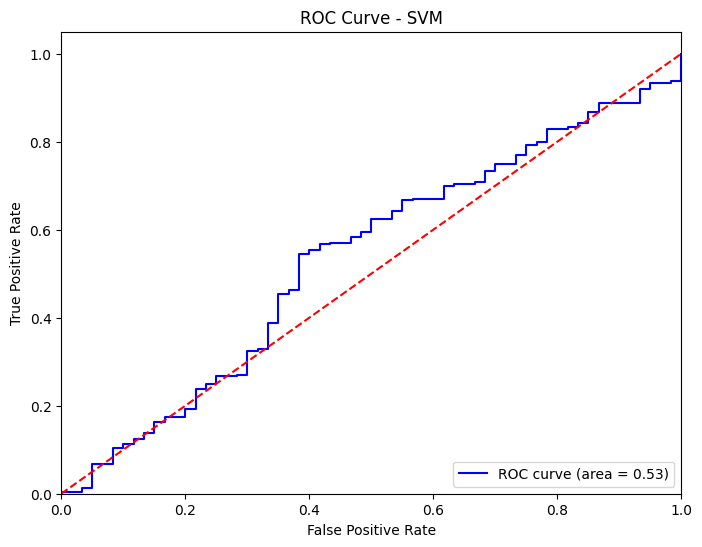

Select any of the model which you need to save from the list

0 - log_reg

1 - decision_tree

2 - random_forest

3 - svm

4 - hyp_log_reg

5 - hyp_decision_tree

6 - hyp_random_forest

7 - hyp_svm


Enter the model number to save the model 6


hyp_random_forest


In [22]:
# Call the main function to run the entire pipeline
if __name__ == "__main__":
    main()

In [ ]:
loan_df = load_data()

In [ ]:
# Loading the saved model
loaded_model = joblib.load('loan_df_model.pkl')
y_pred = loaded_model.predict(X_test)

# Predicting using the loaded model

In [ ]:
# import joblib
# import numpy as np
# import pandas as pd

# # Load the saved model (Logistic Regression for this example)
# loaded_model = joblib.load('logistic_regression_model.pkl')

# # Function to take input values for prediction
# def input_for_prediction():
#     # Input fields
#     age = int(input("Enter age: "))
#     gender = input("Enter gender (Male/Female): ").strip().lower()
#     income = float(input("Enter income: "))
#     employment_status = input("Enter employment status (Employed/Unemployed): ").strip().lower()
#     location = input("Enter location: ").strip().lower()
#     credit_score = float(input("Enter credit score: "))
#     debt_to_income_ratio = float(input("Enter debt-to-income ratio: "))
#     existing_loan_balance = float(input("Enter existing loan balance: "))
#     loan_amount = float(input("Enter loan amount: "))
#     interest_rate = float(input("Enter interest rate: "))
#     loan_duration_months = int(input("Enter loan duration in months: "))

#     # Create a DataFrame with the input values
#     input_data = pd.DataFrame({
#         'Age': [age],
#         'Gender': [1 if gender == 'male' else 0],  # Example: Encode Male as 1, Female as 0
#         'Income': [income],
#         'Employment_Status': [1 if employment_status == 'employed' else 0],  # Example encoding
#         'Location': [location],  # Assuming Location is categorical, will need encoding if trained model used encoding
#         'Credit_Score': [credit_score],
#         'Debt_to_Income_Ratio': [debt_to_income_ratio],
#         'Existing_Loan_Balance': [existing_loan_balance],
#         'Loan_Amount': [loan_amount],
#         'Interest_Rate': [interest_rate],
#         'Loan_Duration_Months': [loan_duration_months]
#     })

#     return input_data

# # Function to make predictions using the loaded model
# def predict_default(input_data):
#     # Make a prediction using the model
#     prediction = loaded_model.predict(input_data)
    
#     # Output the result
#     if prediction == 1:
#         print("The person is predicted to default on the loan.")
#     else:
#         print("The person is predicted not to default on the loan.")

# # Main function to run the input and prediction
# if __name__ == "__main__":
#     input_data = input_for_prediction()
#     predict_default(input_data)


# Main

In [ ]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Function to print model metrics
def print_model_metrics(model_name, y_test, y_pred):
    print(f"{model_name} Metrics:")
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Function to plot ROC curve
def plot_roc_curve(model_name, model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_prob)     # Get FPR and TPR
    roc_auc = auc(fpr, tpr)                     # Calculate AUC

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Function to train Logistic Regression model
def train_logistic_regression(X_train, y_train, X_test, y_test, C, max_iter, solver):
    log_reg = LogisticRegression(C=C, max_iter=max_iter, solver=solver, random_state=42)
    log_reg.fit(X_train, y_train)
    y_pred_log_reg = log_reg.predict(X_test)
    print_model_metrics("Logistic Regression", y_test, y_pred_log_reg)
    plot_roc_curve("Logistic Regression", log_reg, X_test, y_test)

# Function to train Decision Tree model
def train_decision_tree(X_train, y_train, X_test, y_test, min_samples_split, min_samples_leaf, max_depth):
    decision_tree = DecisionTreeClassifier(
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        random_state=42
    )
    decision_tree.fit(X_train, y_train)
    y_pred_tree = decision_tree.predict(X_test)
    print_model_metrics("Decision Tree", y_test, y_pred_tree)
    plot_roc_curve("Decision Tree", decision_tree, X_test, y_test)

# Function to train Random Forest model
def train_random_forest(X_train, y_train, X_test, y_test, n_estimators, min_samples_split, min_samples_leaf, max_depth):
    random_forest = RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        random_state=42
    )
    random_forest.fit(X_train, y_train)
    y_pred_rf = random_forest.predict(X_test)
    print_model_metrics("Random Forest", y_test, y_pred_rf)
    plot_roc_curve("Random Forest", random_forest, X_test, y_test)

# Function to train Support Vector Machine (SVM) model
def train_svm(X_train, y_train, X_test, y_test, C, gamma, kernel):
    svm = SVC(C=C, gamma=gamma, kernel=kernel, probability=True, random_state=42)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    print_model_metrics("SVM", y_test, y_pred_svm)
    plot_roc_curve("SVM", svm, X_test, y_test)

# Main function to call all model training functions
def main():
    # Sample hyperparameters
    C_l = 1.0
    max_iter = 100
    solver = 'lbfgs'
    min_samples_split = 2
    min_samples_leaf = 1
    max_depth = 5
    n_estimators = 100
    C_s = 1.0
    gamma = 'scale'
    kernel = 'rbf'
    
    # Load your training and testing data (replace with actual data loading code)
    X_train, X_test, y_train, y_test = load_data()  # Replace with actual data loading logic
    
    # Train Logistic Regression
    train_logistic_regression(X_train, y_train, X_test, y_test, C_l, max_iter, solver)
    
    # Train Decision Tree
    train_decision_tree(X_train, y_train, X_test, y_test, min_samples_split, min_samples_leaf, max_depth)
    
    # Train Random Forest
    train_random_forest(X_train, y_train, X_test, y_test, n_estimators, min_samples_split, min_samples_leaf, max_depth)
    
    # Train SVM
    train_svm(X_train, y_train, X_test, y_test, C_s, gamma, kernel)

# Placeholder function to simulate loading data
def load_data():
    # Replace with actual data loading code
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

# Call the main function to run the entire pipeline
if __name__ == "__main__":
    main()
